In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from tensorflow.keras.optimizers.legacy import Nadam
import random

import sys
sys.path.append('/home/drishya/Desktop/NLP/NER')

from script.preprocessing import preprocessing_dataframe
from script.training import TRAINING_CNN_BLSTM
from script.utils_function import *

2023-10-18 09:59:40.017493: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 09:59:40.017530: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 09:59:40.017560: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-18 09:59:40.029583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 09:59:41.301688: W tensorflow/compiler/

In [5]:
data_train = pd.read_excel('data/ner_dataset_train.xlsx')
data_train = data_train.dropna().reset_index(drop=True)

data_test = pd.read_excel('data/ner_dataset_test.xlsx')
data_test = data_test.dropna().reset_index(drop=True)

print(data_train.shape, data_test.shape)
data_train.head()

(30559, 3) (10245, 3)


,Intent,Parameters,Question
0,B-gpe,"[[0, 7, ""B-gpe""]]",Israeli police investigating a money-launderin...
1,B-perI-perB-orgI-orgB-tim,"[[0, 7, ""B-per""], [8, 14, ""I-per""], [32, 42, ""...",Senator McCain could secure the Republican Par...
2,B-gpeB-tim,"[[0, 8, ""B-gpe""], [58, 64, ""B-tim""]]",American consumers fear prices will go even hi...
3,B-gpeB-gpeB-tim,"[[4, 10, ""B-gpe""], [35, 42, ""B-gpe""], [134, 13...",The Syrian newspaper is calling on Israeli off...
4,B-geoB-geoI-geoB-perB-gpeB-orgB-tim,"[[29, 32, ""B-geo""], [111, 120, ""B-geo""], [33, ...",Despite her absence from the New Zealand event...


In [6]:
#Preprocess Train set
data_train = preprocessing_dataframe(data_train)
data_train.remove_label(labels=['Tag','B-art', 'B-eve', 'B-nat', 'I-art', 'I-eve', 'I-nat'])
data_train.remove_higher_len(len_threshold=40)
list_labels = data_train.preprocessing_ner()
data_train.create_target(list_labels)
data_train.split_word_char_label()

#Preprocess Test set
data_test = preprocessing_dataframe(data_test)
data_test.remove_label(labels=['Tag','B-art', 'B-eve', 'B-nat', 'I-art', 'I-eve', 'I-nat'])
data_test.remove_higher_len(len_threshold=40)
_ = data_test.preprocessing_ner()
data_test.create_target(list_labels)
data_test.split_word_char_label()

In [7]:
data_train.head()

,Intent,Parameters,Question,Preprocess_Question,Target,input
0,B-gpe,"[[0, 7, ""B-gpe""]]",Israeli police investigating a money-launderin...,B-gpe police investigating a money-laundering ...,B-gpe O O O O O O O O O O O O O O O,"[[Israeli, [I, s, r, a, e, l, i], B-gpe], [pol..."
1,B-perI-perB-orgI-orgB-tim,"[[0, 7, ""B-per""], [8, 14, ""I-per""], [32, 42, ""...",Senator McCain could secure the Republican Par...,B-per I-per could secure the B-org I-org nomin...,B-per I-per O O O B-org I-org O O O B-tim,"[[Senator, [S, e, n, a, t, o, r], B-per], [McC..."
2,B-gpeB-tim,"[[0, 8, ""B-gpe""], [58, 64, ""B-tim""]]",American consumers fear prices will go even hi...,B-gpe consumers fear prices will go even highe...,B-gpe O O O O O O O O O B-tim O O O O,"[[American, [A, m, e, r, i, c, a, n], B-gpe], ..."
3,B-gpeB-gpeB-tim,"[[4, 10, ""B-gpe""], [35, 42, ""B-gpe""], [134, 13...",The Syrian newspaper is calling on Israeli off...,The B-gpe newspaper is calling on B-gpe offici...,O B-gpe O O O O B-gpe O O O O O O O O O O O O ...,"[[The, [T, h, e], O], [Syrian, [S, y, r, i, a,..."
4,B-geoB-geoI-geoB-perB-gpeB-orgB-tim,"[[29, 32, ""B-geo""], [111, 120, ""B-geo""], [33, ...",Despite her absence from the New Zealand event...,Despite her absence from the B-geo I-geo event...,O O O O O B-geo I-geo O O O O O O O B-per O O ...,"[[Despite, [D, e, s, p, i, t, e], O], [her, [h..."


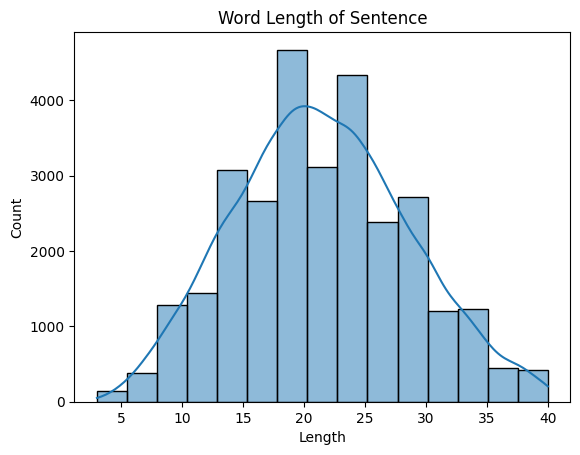

In [8]:
len_list = [len(x.split()) for x in data_train['Preprocess_Question']]
sns.histplot(len_list, kde=True, bins=15)
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Word Length of Sentence');

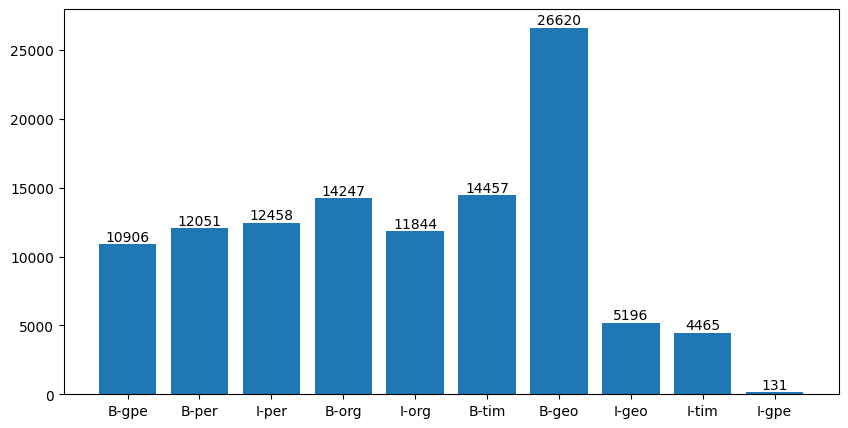

In [9]:
from collections import Counter

list_label = [x for y in data_train.Target for x in y.split()]
list_label = [x for x in list_label if x != 'O']

element_counts = Counter(list_label)
elements, counts = zip(*element_counts.items())

plt.figure(figsize=(10, 5))
plt.bar(elements, counts)

for i in range(len(elements)):
    plt.text(elements[i], counts[i], str(counts[i]), ha='center', va='bottom')

plt.show()

In [11]:
def plot_square_area(label, threshold=100):
  
    label_dict = {}

    for sent in data_train.input:
        for word in sent:
            if word[2] == label:
                if word[0] in label_dict:
                    label_dict[word[0]] +=1
                else:
                    label_dict[word[0]] =1 

    threshold = threshold
    filtered_data = {k: v for k, v in label_dict.items() if v > threshold}

    categories = list(filtered_data.keys())
    values = list(filtered_data.values())

    total = sum(values)
    normalized_values = [(v / total) * 100 for v in values]
    colors = [plt.cm.tab20c(random.random()) for _ in range(len(categories))]

    # Plot the proportional square area chart
    plt.figure(figsize=(8, 6))
    squarify.plot(sizes=normalized_values, label=categories, color=colors, alpha=0.7)
    plt.axis('off')  
    plt.title(f'Proportional Square Area Chart of {label} (Values > {threshold})')
    plt.show()

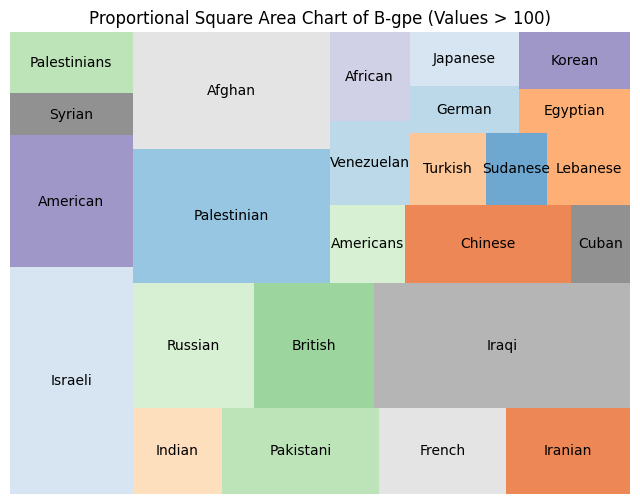

In [12]:
plot_square_area('B-gpe')

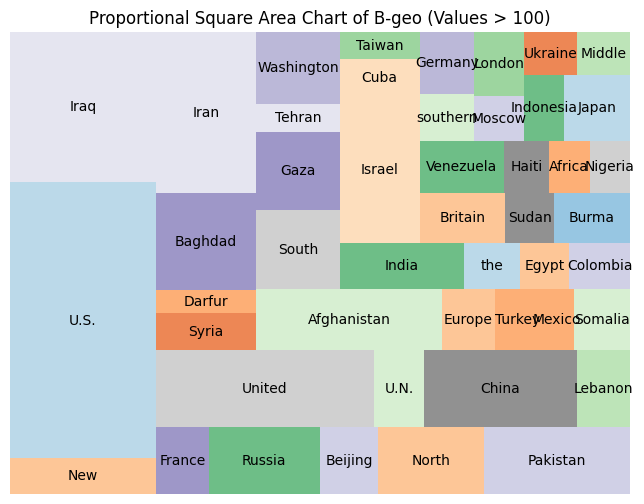

In [14]:
plot_square_area('B-geo')

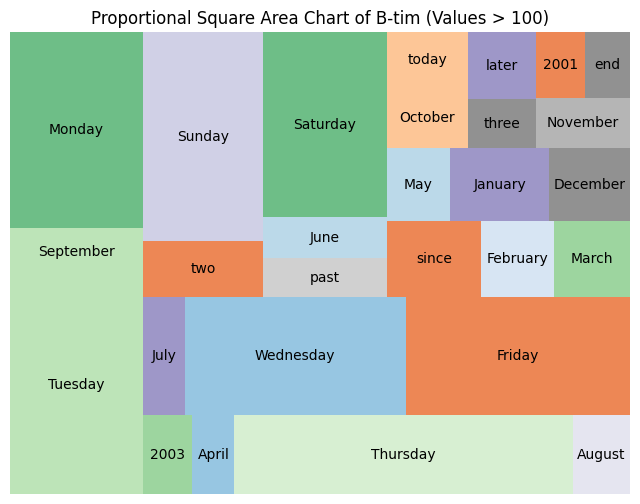

In [15]:
plot_square_area('B-tim')

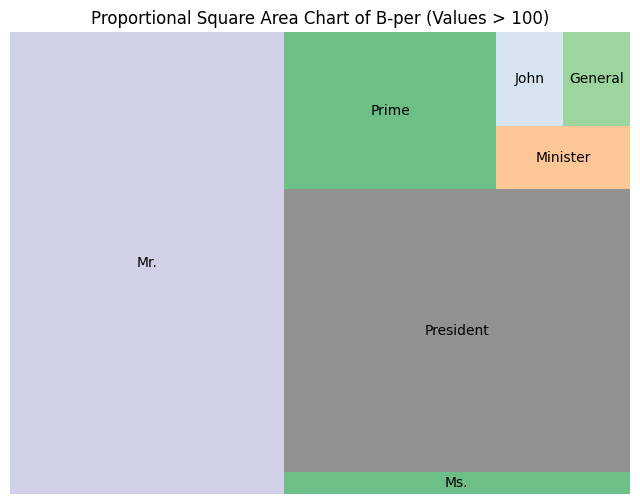

In [16]:
plot_square_area('B-per')

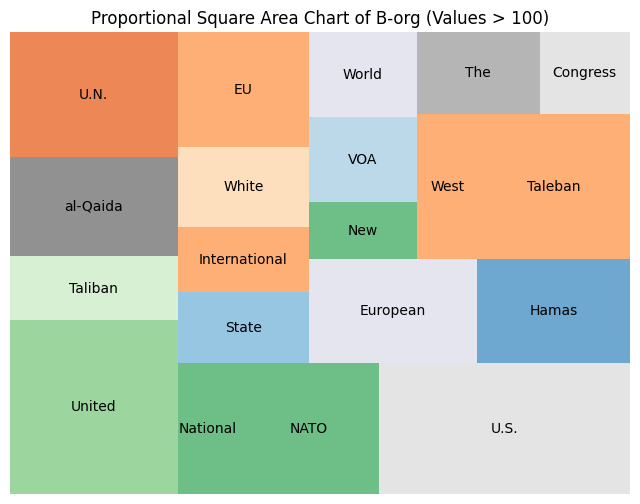

In [22]:
plot_square_area('B-org')

In [8]:
EPOCHS = 100               
DROPOUT = 0.5               
DROPOUT_RECURRENT = 0      
LSTM_STATE_SIZE = 250      
CONV_SIZE = 3               
LEARNING_RATE = 0.015      
OPTIMIZER = Nadam()        
MAX_LEN = 40  

DATA_TRAIN = data_train
DATA_TEST = data_test

In [9]:
model = TRAINING_CNN_BLSTM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER, MAX_LEN, DATA_TRAIN, DATA_TEST)
model.embedding()
model.createBatches()

In [10]:
model.build_model(print_summary=True, save_model_image=True)

2023-10-17 07:41:57.499600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 07:41:57.575816: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model is built. Image of model is saved completely
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Character_input (InputLaye  [(None, None, 40)]           0         []                            
 r)                                                                                               
                                                                                                  
 Character_embedding (TimeD  (None, None, 40, 30)         2910      ['Character_input[0][0]']     
 istributed)                                                                                      
                                                                                            

In [11]:
model.train_model(name='finalModel_100epochs')

2023-10-17 07:42:00.460918: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15105600 exceeds 10% of free system memory.
2023-10-17 07:42:00.465301: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15105600 exceeds 10% of free system memory.
2023-10-17 07:42:02.353773: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15105600 exceeds 10% of free system memory.
2023-10-17 07:42:02.353858: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15105600 exceeds 10% of free system memory.
2023-10-17 07:42:02.397041: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15105600 exceeds 10% of free system memory.


Epoch 0/100
Macro F1 Score: 0.1803377079024485 - Testing by sampling 1000 sentences randomly from test data.
Epoch 10/100
Macro F1 Score: 0.6654886212349346 - Testing by sampling 1000 sentences randomly from test data.
Epoch 20/100
Macro F1 Score: 0.7111503107702958 - Testing by sampling 1000 sentences randomly from test data.
Epoch 30/100
Macro F1 Score: 0.7740103749079313 - Testing by sampling 1000 sentences randomly from test data.
Epoch 40/100
Macro F1 Score: 0.7299512599476387 - Testing by sampling 1000 sentences randomly from test data.
Epoch 50/100
Macro F1 Score: 0.7888679030333449 - Testing by sampling 1000 sentences randomly from test data.
Epoch 60/100
Macro F1 Score: 0.8008830149381776 - Testing by sampling 1000 sentences randomly from test data.
Epoch 70/100
Macro F1 Score: 0.741603693990125 - Testing by sampling 1000 sentences randomly from test data.
Epoch 80/100
Macro F1 Score: 0.8001795062269553 - Testing by sampling 1000 sentences randomly from test data.
Epoch 90/100

/home/drishya/Desktop/ner-model-from-scratch-ver1/ner/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
model.evaluate_model()

Model is evaluated on test set which has 9886 sentences.
------------------------------------------------------------
Predicting in progress ___ 9886 sentences remaining.
Predicting in progress ___ 8386 sentences remaining.
Predicting in progress ___ 6886 sentences remaining.
Predicting in progress ___ 5386 sentences remaining.
Predicting in progress ___ 3886 sentences remaining.
Predicting in progress ___ 2386 sentences remaining.
